## Human in the loop

In [38]:
import os 
from langchain.chat_models import init_chat_model
llm = init_chat_model('groq:llama-3.1-8b-instant')
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000020F51B25D10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000020F51B26850>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [39]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str)->str :
    """Request assistance from a human"""
    human_response = interrupt({'query': query})
    return human_response['data']

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message= llm_with_tools.invoke(state['messages'])
    # because we will be intterupting during tool execution, we disable parralel tool calling to avoid repeating any tool invocations wehn we resume.
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node =ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START, "chatbot")


In [40]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

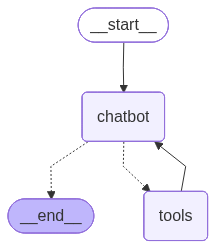

In [41]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [43]:
user_input = "i need some export guidance and assistance for building an ai agent. could you request assistance for me?"
config = {"configurable": {"thread_id":"1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

i need some export guidance and assistance for building an ai agent. could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (mcs6xtj3k)
 Call ID: mcs6xtj3k
  Args:
    query: export guidance and assistance for building an AI agent
  tavily_search (wycnewe6z)
 Call ID: wycnewe6z
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_images: False
    query: export guidance for building an AI agent
    search_depth: advanced
    start_date: None
    time_range: None
    topic: general
================================== Ai Message ==================================
Tool Calls:
  human_assistance (mcs6xtj3k)
 Call ID: mcs6xtj3k
  Args:
    query: export guidance and assistance for building an AI agent
  tavily_search (wycnewe6z)
 Call ID: wycnewe6z
  Args:
    end_date: None
    ex

In [44]:
human_input = (
    "We, the experts are here to help we'd recoomend you check out langgraph to build your agetn."
    "It's much more reliable and extensible than simple autonomus agents."
)

human_command = Command(resume={"data": human_input})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (mcs6xtj3k)
 Call ID: mcs6xtj3k
  Args:
    query: export guidance and assistance for building an AI agent
  tavily_search (wycnewe6z)
 Call ID: wycnewe6z
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_images: False
    query: export guidance for building an AI agent
    search_depth: advanced
    start_date: None
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "export guidance for building an AI agent", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://mobidev.biz/blog/how-to-build-ai-agents-development-guide", "title": "AI Agent Development Explained for Business Leaders: 2025 Guide", "content": "For larger systems, cloud providers such as AWS, Azure, or Google Cloud AI offer built-in soluti